!pip install crr_labels epigenomic_dataset \
 ucsc_genomes_downloader cache_decorator minepy &> /dev/null && echo "done"

In [1]:
!pip install crr_labels epigenomic_dataset extra_keras_metrics \
    keras_mixed_sequence keras_bed_sequence ucsc_genomes_downloader \
    cache_decorator minepy &> /dev/null && echo "done"
!pip install -Iv humanize==3.9.0 &> /dev/null && echo "done"
!pip install --upgrade tbb

done
done
Requirement already up-to-date: tbb in /usr/local/lib/python3.7/dist-packages (2021.2.0)


In [27]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
import seaborn as sbn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Retrive epigenomic data

In [2]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 256


aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    #root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

apip_X, apip_y = active_promoters_vs_inactive_promoters(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    #root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

# Retrive genomic sequence

In [5]:
from ucsc_genomes_downloader import Genome

genome = Genome(
    "hg38",
    cache_directory="/content/drive/MyDrive/bio-data/genomes"
)

In [ ]:
genome

Human, Homo sapiens, hg38, 2013-12-27, 25 chromosomes

In [6]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# Describe dataset

In [3]:
aeie_X

chrom                              SMAD5  NCOA2  ZNF23  NR2F6  CEBPZ  SNIP1  \
chrom chromStart chromEnd  strand                                             
chr10 100006381  100006637 .        0.90   0.90   1.37   0.67   0.58   1.19   
      100008146  100008402 .        0.73   1.06   0.74   0.42   0.61   0.81   
      100014418  100014674 .        0.77   0.33   0.53   0.58   0.82   1.98   
      100020216  100020472 .        0.87   0.80   0.83   0.63   0.82   0.94   
      100043528  100043784 .        0.64   0.53   0.03   0.60   0.99   0.22   
...                                  ...    ...    ...    ...    ...    ...   
chrY  7520247    7520503   .        0.00   0.00   0.00   0.00   0.00   0.00   
      7724272    7724528   .        0.00   0.00   0.00   0.00   0.00   0.00   
      7770029    7770285   .        0.00   0.00   0.00   0.00   0.00   0.00   
      7796295    7796551   .        0.00   0.00   0.00   0.00   0.00   0.00   
      8007562    8007818   .        0.00   0.00   0.00   0.00   0.00   0.00   

chrom                              ZBTB7A  ZNF133  NRF1  TAF1  ...  SIN3A  \
chrom chromStart chromEnd  strand                              ...          
chr10 100006381  100006637 .         0.79    0.86  1.22  0.00  ...   0.41   
      100008146  100008402 .         0.95    0.59  0.65  1.46  ...   0.94   
      100014418  100014674 .         0.15    0.99  0.85  0.51  ...   0.72   
      100020216  100020472 .         0.56    0.81  0.74  2.38  ...   0.74   
      100043528  100043784 .         0.28    0.55  0.69  2.04  ...   0.30   
...                                   ...     ...   ...   ...  ...    ...   
chrY  7520247    7520503   .         0.00    0.00  0.00  0.00  ...   0.00   
      7724272    7724528   .         0.00    0.00  0.00  0.00  ...   0.00   
      7770029    7770285   .         0.00    0.00  0.00  0.00  ...   0.00   
      7796295    7796551   .         0.00    0.00  0.00  0.00  ...   0.00   
      8007562    8007818   .         0.00    0.00  0.00  0.00  ...   0.00   

chrom                              SMARCC2  ZFP91  E2F4  NR3C1  SAFB2  E4F1  \
chrom chromStart chromEnd  strand                                             
chr10 100006381  100006637 .          3.41   1.07  1.15   1.19   0.99  2.74   
      100008146  100008402 .          1.20   0.77  1.54   0.88   2.21  1.11   
      100014418  100014674 .          0.95   0.39  0.00   0.42   0.45  1.56   
      100020216  100020472 .          0.73   0.55  0.15   1.02   0.32  1.06   
      100043528  100043784 .          0.69   1.32  0.00   0.70   0.51  0.38   
...                                    ...    ...   ...    ...    ...   ...   
chrY  7520247    7520503   .          0.00   0.00  0.00   0.00   0.00  0.00   
      7724272    7724528   .          0.00   0.00  0.00   0.00   0.00  0.17   
      7770029    7770285   .          0.00   0.00  0.00   0.00   0.00  0.00   
      7796295    7796551   .          0.00   0.00  0.00   0.00   0.00  0.00   
      8007562    8007818   .          0.00   0.00  0.00   0.00   0.00  0.00   

chrom                              NCOR1  NCOA1  KLF1  
chrom chromStart chromEnd  strand                      
chr10 100006381  100006637 .        2.38   0.82  0.69  
      100008146  100008402 .        3.11   0.49  1.05  
      100014418  100014674 .        0.61   0.97  0.96  
      100020216  100020472 .        0.57   0.03  1.07  
      100043528  100043784 .        1.26   1.73  0.33  
...                                  ...    ...   ...  
chrY  7520247    7520503   .        0.00   0.00  0.00  
      7724272    7724528   .        0.00   0.00  0.00  
      7770029    7770285   .        0.00   0.00  0.00  
      7796295    7796551   .        0.00   0.00  0.00  
      8007562    8007818   .        0.00   0.00  0.00  

[63285 rows x 429 columns]

In [4]:
aeie_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63284.000000,63285.000000,63285.000000,63284.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.854204,0.743733,0.831215,0.800811,0.864409,0.804661,1.245513,0.907048,1.021286,1.101227,...,0.929765,0.976732,0.862212,1.429998,0.810822,0.649336,1.008343,1.075286,0.808300,0.942412
std,0.878816,0.334574,0.532511,0.334844,0.581483,0.453880,2.228033,0.464311,4.122830,2.245365,...,0.825980,0.777798,1.610566,2.560798,0.425050,0.509271,1.594609,1.834175,0.520243,0.563087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.460000,0.520000,0.470000,0.590000,0.510000,0.490000,0.310000,0.580000,0.450000,0.000000,...,0.530000,0.480000,0.510000,0.060000,0.510000,0.270000,0.470000,0.450000,0.480000,0.610000
50%,0.720000,0.720000,0.740000,0.780000,0.800000,0.770000,0.690000,0.850000,0.660000,0.530000,...,0.780000,0.820000,0.760000,0.830000,0.770000,0.550000,0.780000,0.770000,0.770000,0.870000
75%,1.030000,0.930000,1.080000,0.980000,1.140000,1.060000,1.350000,1.160000,0.920000,1.280000,...,1.110000,1.260000,1.050000,1.800000,1.060000,0.930000,1.200000,1.200000,1.080000,1.170000
max,35.750000,6.470000,28.540000,7.480000,47.370000,21.400000,68.250000,9.480000,242.180000,64.490000,...,24.170000,11.920000,141.530000,96.300000,5.020000,4.700000,175.740000,111.920000,37.360000,34.320000


In [5]:
aeie_y

K562
chrom chromStart chromEnd  strand       
chr10 100006381  100006637 .       False
      100008146  100008402 .       False
      100014418  100014674 .       False
      100020216  100020472 .       False
      100043528  100043784 .       False
...                                  ...
chrY  7520247    7520503   .       False
      7724272    7724528   .       False
      7770029    7770285   .       False
      7796295    7796551   .       False
      8007562    8007818   .       False

[63285 rows x 1 columns]

In [6]:
aeie_y.describe()

,K562
count,63285
unique,2
top,False
freq,62884


In [7]:
apip_X

chrom                              SMAD5  NCOA2  ZNF23  NR2F6  CEBPZ  SNIP1  \
chrom chromStart chromEnd  strand                                             
chr1  628964     629220    +        0.14   1.00   0.19   1.01   0.60   0.38   
      629013     629269    +        0.14   0.97   0.20   0.89   0.43   0.43   
      629642     629898    +        0.00   0.11   0.11   0.06   0.00   0.10   
      629847     630103    +        0.12   1.07   0.91   0.41   0.60   0.73   
      629905     630161    +        0.49   1.37   1.02   0.41   0.60   0.92   
...                                  ...    ...    ...    ...    ...    ...   
chrX  154441877  154442133 +        1.35   0.56   0.46   0.91   0.14   0.45   
      154584927  154585183 +        0.00   0.00   0.00   0.00   0.00   0.00   
chrY  1452882    1453138   -        0.00   0.00   0.00   0.00   0.00   0.00   
      2500959    2501215   -        0.00   0.00   0.00   0.00   0.00   0.00   
      14055973   14056229  +        0.00   0.00   0.00   0.00   0.00   0.00   

chrom                              ZBTB7A  ZNF133  NRF1  TAF1  ...  SIN3A  \
chrom chromStart chromEnd  strand                              ...          
chr1  628964     629220    +         0.50    0.57  0.47  0.00  ...   0.28   
      629013     629269    +         0.50    0.53  0.45  0.00  ...   0.19   
      629642     629898    +         0.00    0.22  0.14  0.00  ...   0.11   
      629847     630103    +         0.00    1.25  0.63  0.07  ...   0.31   
      629905     630161    +         0.00    1.24  0.70  0.58  ...   0.57   
...                                   ...     ...   ...   ...  ...    ...   
chrX  154441877  154442133 +         1.15    1.48  0.19  1.67  ...   0.52   
      154584927  154585183 +         0.00    0.00  0.00  0.00  ...   0.00   
chrY  1452882    1453138   -         0.00    0.00  0.00  0.00  ...   0.00   
      2500959    2501215   -         0.00    0.00  0.00  0.00  ...   0.00   
      14055973   14056229  +         0.00    0.00  0.00  0.00  ...   0.00   

chrom                              SMARCC2  ZFP91  E2F4  NR3C1  SAFB2  E4F1  \
chrom chromStart chromEnd  strand                                             
chr1  628964     629220    +          0.99   0.65  0.00   0.58   0.63  1.54   
      629013     629269    +          0.71   0.49  0.00   0.64   0.33  1.54   
      629642     629898    +          0.25   0.25  0.00   0.29   1.14  0.11   
      629847     630103    +          1.10   1.08  0.95   1.61   1.38  0.53   
      629905     630161    +          1.31   1.14  1.40   2.01   0.59  0.79   
...                                    ...    ...   ...    ...    ...   ...   
chrX  154441877  154442133 +          0.42   0.14  5.55   0.98   0.00  0.78   
      154584927  154585183 +          0.00   0.00  0.00   0.00   0.00  0.00   
chrY  1452882    1453138   -          0.00   0.00  0.00   0.00   0.00  0.00   
      2500959    2501215   -          0.00   0.00  0.00   0.00   0.00  0.00   
      14055973   14056229  +          0.00   0.00  0.00   0.00   0.00  0.00   

chrom                              NCOR1  NCOA1  KLF1  
chrom chromStart chromEnd  strand                      
chr1  628964     629220    +        1.40   1.74  1.59  
      629013     629269    +        1.42   1.63  1.21  
      629642     629898    +        0.00   0.16  0.09  
      629847     630103    +        0.40   0.60  0.88  
      629905     630161    +        0.54   0.61  1.15  
...                                  ...    ...   ...  
chrX  154441877  154442133 +        0.55   0.77  0.72  
      154584927  154585183 +        0.00   0.00  0.00  
chrY  1452882    1453138   -        0.00   0.00  0.00  
      2500959    2501215   -        0.00   0.00  0.00  
      14055973   14056229  +        0.00   0.00  0.00  

[99881 rows x 429 columns]

In [8]:
apip_X.describe()

chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,...,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000
mean,2.238571,0.657735,0.879565,0.860949,1.241882,0.831541,3.811772,1.017048,8.070131,6.555876,...,2.409723,0.981741,1.510206,7.417156,0.797512,0.601236,2.889943,1.165788,0.699335,1.298927
std,2.650387,0.930009,0.589551,0.391718,2.192965,1.723633,5.233189,0.522413,23.177855,10.750923,...,2.873567,0.686464,6.726482,13.299242,0.500373,0.441843,16.807033,1.482469,0.462811,1.111308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.620000,0.410000,0.460000,0.620000,0.560000,0.390000,0.760000,0.650000,0.570000,0.450000,...,0.680000,0.490000,0.520000,0.870000,0.440000,0.280000,0.490000,0.440000,0.370000,0.660000
50%,1.100000,0.600000,0.790000,0.830000,0.950000,0.690000,1.910000,0.960000,1.040000,1.760000,...,1.230000,0.890000,0.860000,2.560000,0.760000,0.530000,1.010000,0.880000,0.650000,1.040000
75%,3.070000,0.800000,1.190000,1.060000,1.450000,1.020000,4.810000,1.310000,3.560000,8.560000,...,3.270000,1.350000,1.260000,9.110000,1.090000,0.840000,2.210000,1.510000,0.970000,1.620000
max,55.770000,38.470000,24.840000,16.170000,78.080000,148.680000,116.890000,7.420000,428.950000,226.500000,...,51.440000,12.940000,353.440000,325.240000,9.970000,3.860000,914.370000,66.960000,11.170000,46.240000


In [9]:
apip_y

K562
chrom chromStart chromEnd  strand       
chr1  628964     629220    +       False
      629013     629269    +       False
      629642     629898    +       False
      629847     630103    +       False
      629905     630161    +        True
...                                  ...
chrX  154441877  154442133 +       False
      154584927  154585183 +       False
chrY  1452882    1453138   -       False
      2500959    2501215   -       False
      14055973   14056229  +       False

[99881 rows x 1 columns]

In [10]:
apip_y.describe()

,K562
count,99881
unique,2
top,False
freq,78250


In [11]:
epigenomes = {
    "promoters": apip_X,
    "enhancers": aeie_X,
}

labels = {
    "promoters": apip_y,
    "enhancers": aeie_y,
}

## Feature sample ratio

In [13]:
for region, X in epigenomes.items():
    print(f"Feature sample ratio for {region} = {X.shape[0] / X.shape[1]}")

Feature sample ratio for promoters = 232.82284382284382
Feature sample ratio for enhancers = 147.5174825174825


## Nan detection

In [14]:
for region, X in epigenomes.items():
    print(region)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")
    print("=" * 30)

promoters
Total NaN values: 496/42848949
Max NaN in a row: 20/429
Max NaN in a feature: 250/99881
enhancers
Total NaN values: 102/27149265
Max NaN in a row: 7/429
Max NaN in a feature: 93/63285


## Class balance

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Active-Inactive promoters ratio: 0.2764345047923323
Active fraction in promoters: 0.21656771558154203
Active-Inactive enhancers ratio: 0.006376820812925387
Active fraction in enhancers: 0.006336414632219325


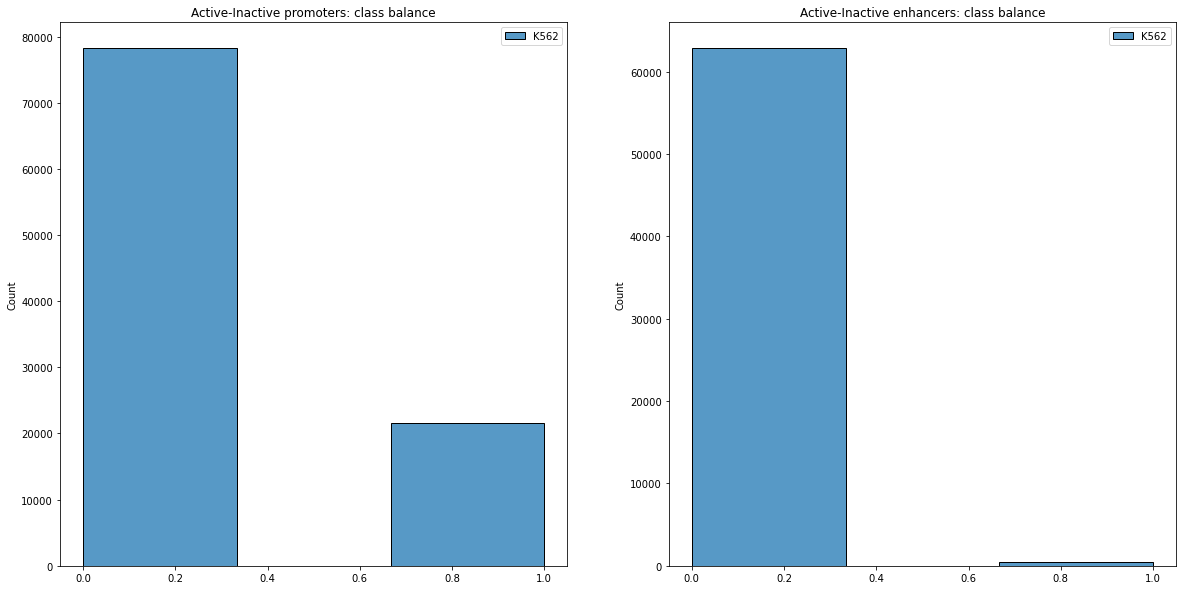

In [15]:
_, axs = plt.subplots(ncols=2, figsize=(20, 10))
for i, (region, y) in enumerate(labels.items()):
    axes = sbn.histplot(
        data=y,
        bins=3,
        ax=axs[i],
    )

    axes.set_title(f"Active-Inactive {region}: class balance")
    counts = y[cell_line].value_counts()
    print(f"Active-Inactive {region} ratio: {counts[1]/counts[0]}")
    print(f"Active fraction in {region}: {counts[1]/(counts[0]+counts[1])}")

# Data preprocessing

In [36]:
def binarize(
    y: pd.DataFrame,
    cell_line: str
)-> pd.DataFrame:
    return y[cell_line].astype(int)

In [37]:
from sklearn.feature_selection import VarianceThreshold

def drop_constant_features(X: pd.DataFrame) -> (pd.DataFrame, bool):
    """Return a DataFrame without constant features in in.

    Parameters
    ----------------
    X: pd.DataFrame
        The dataframe to process.

    Returns
    ----------------
    A tuple with the new DataFrame and a boolean value to point out if the
    new DataFrame is distinct from the input one.
    """
    constant_feature_selector = VarianceThreshold()
    new_X = constant_feature_selector.fit_transform(X)
    return (new_X, new_X.shape[1] != X.shape[1])

In [38]:
def impute_with_median(X: pd.DataFrame) -> pd.DataFrame:
    return X.fillna(X.median())

In [39]:
from sklearn.preprocessing import RobustScaler

def robust_scaler(X: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(X.values),
        columns=X.columns,
        index=X.index
    )

In [40]:
from typing import Tuple

def preprocess_dataset(
    X: pd.DataFrame,
    y: pd.DataFrame,
    region: str,
    cell_line: str,
    binary: bool=True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    y_new = y
    if binary: 
        y_new[cell_line] = binarize(
            y_new,
            cell_line
        )
    X_new, ok = drop_constant_features(X)
    if not ok: 
        print(f"{region} doesn't have costant features.")
        X_new = X
    X_new = impute_with_median(X_new)
    return robust_scaler(X_new), y_new

In [41]:
for region, X in epigenomes.items():
    epigenomes[region], labels[region] = preprocess_dataset(
        X,
        labels[region],
        region,
        cell_line,
        binary=True,
    )

promoters doesn't have costant features.
enhancers doesn't have costant features.


# Verify output correlation

In [42]:
from scipy.stats import pearsonr
from typing import Set

def pearson_corr_output(
    X: pd.DataFrame,
    y: np.ndarray,
    region: str,
    p_value_threshold: float = 0.01,
) -> Set:
    uncorrelated_features_with_output = set()

    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [43]:
from scipy.stats import spearmanr


def spearman_corr_output(
    X: pd.DataFrame,
    y: np.ndarray,
    region: str,
    p_value_threshold: float = 0.01,
) -> Set:
    uncorrelated_features_with_output = set()
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            y
        )
        if p_value > p_value_threshold:
            uncorrelated_features_with_output.add(feature)

    return uncorrelated_features_with_output

In [32]:
from minepy import MINE

# @Cache(
#     cache_path="outcorr/mine/{region}/{_hash}.pkl.gz",
#     args_to_ignore=["X", "y"]
# )
def mic_corr_output(
    X: pd.DataFrame,
    y: np.ndarray,
    region: str,
    uncorrelated_features: Dict,
    score_threshold: float = 0.05,
) -> Dict:
    for feature in tqdm(
        uncorrelated_features[region],
        desc = f"Running MINE test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        mine = MINE()
        mine.compute_score(
            X[feature].values.ravel(),
            y
        )
        score = mine.mic()
        if score >= score_threshold:
            uncorrelated_features[region].remove(feature)

    return uncorrelated_features_with_output

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
output_corr = {
    region: set()
    for region in epigenomes.keys()
}

for region, X in epigenomes.items():
    output_corr[region] = pearson_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )
    output_corr[region] = spearman_corr_output(
        X,
        labels[region].values.ravel(),
        region
    )

output_corr

Running Person test for promoters:   0%|          | 0/429 [00:00<?, ?it/s]

Running Spearman test for promoters:   0%|          | 0/429 [00:00<?, ?it/s]

Running Person test for enhancers:   0%|          | 0/429 [00:00<?, ?it/s]

Running Spearman test for enhancers:   0%|          | 0/429 [00:00<?, ?it/s]

In [ ]:
for region, X in epigenomes.items():
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])

In [ ]:
for _, X in epigenomes.items():
    print(X.shape)

# Feature Correlation

In [ ]:
from scipy.stats import entropy
from typing import List

def features_correlation(
    X: pd.DataFrame,
    p_value_threshold: float = 0.01,
    correlation_threshold: float = 0.95
) -> List:
    scores = []

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores.append((correlation, feature_1, feature_2))
    #        if p_value < p_value_threshold and np.abs(correlation) > correlation_threshold:
    #            print(f"High correlation (Pearson): {feature_1} with {feature_2} ({correlation})")
    #            if entropy(X[feature_1]) > entropy(X[feature_2]):
    #                high_correlation[region].add(feature_2)
    #            else:
    #                high_correlation[region].add(feature_1)
    
    return scores

In [ ]:
result = {}

for region, X in epigenomes.items():
    result[region] = features_correlation(X, region)

In [ ]:
scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in result.items()
}

In [ ]:
for region, X in epigenomes.items():
    # take the first three elems, unwrap them and then merge togheter
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sbn.pairplot(pd.concat([
        X[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

# Feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

for region, X in epigenomes.items():
    print(f"Feature selection for {region}")
    clf = ExtraTreesClassifier(
        n_estimators=50,
        max_depth=10
    )
    clf.fit(X, labels[region].values.ravel())
    model = SelectFromModel(clf, prefit=True)
    X_new = pd.DataFrame(
        model.transform(X),
        columns=X.columns[model.get_support()],
        index=X.index
    )
    print(f"new shape: {X_new.shape}")
    epigenomes[region] = X_new

# Data visualization

In [12]:
from sklearn.decomposition import PCA

def pca_decomposition(
    X: np.ndarray,
    components: int = 2
) -> np.ndarray:
    return PCA(n_components=components).fit_transform(X)

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE

@Cache(
    cache_path="decomposition/tsne/{task}/{perplexity}_{dimensionality_threshold}_{_hash}.pkl.gz",
    args_to_ignore=["X"]
)
def tsne_decomposition(
    X:np.ndarray,
    perplexity:int,
    task:str,
    dimensionality_threshold:int=50,
) -> np.ndarray:
    if X.shape[1] > dimensionality_threshold:
        X = pca_decomposition(X, components=dimensionality_threshold)
    return TSNE(
        perplexity=perplexity,
        n_jobs=cpu_count(),
        random_state=42
    ).fit_transform(X)

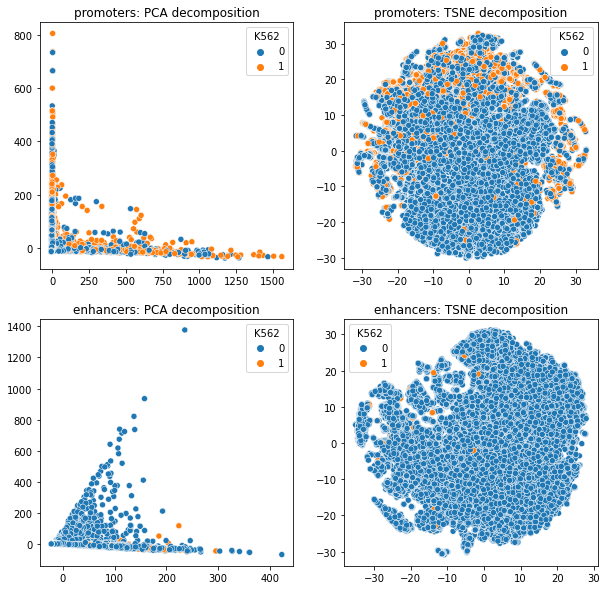

In [16]:
_, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 10)
)

for i, (region, X) in enumerate(epigenomes.items()):
    pca_dec = pca_decomposition(X.values)
    tsne_dec = tsne_decomposition(
        X.values,
        perplexity=30,
        task=region,
        dimensionality_threshold=50,
    )
    
    ax = sbn.scatterplot(
        x=pca_dec.T[0],
        y=pca_dec.T[1],
        hue=labels[region][cell_line],
        ax=axs[i][0]
    )
    ax.set_title(f"{region}: PCA decomposition")
    
    ax = sbn.scatterplot(
        x=tsne_dec.T[0],
        y=tsne_dec.T[1],
        hue=labels[region][cell_line],
        ax=axs[i][1]
    )
    ax.set_title(f"{region}: TSNE decomposition")
    

# Model creation

In [13]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_complete_binary_metrics, get_standard_binary_metrics,get_minimal_multiclass_metrics
from keras_mixed_sequence import MixedSequence, VectorSequence
from tqdm.keras import TqdmCallback

In [34]:
def build_fixed_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(256, activation="relu")(input_epigenomic_data)
    hidden = Dense(128, activation="relu")(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryFixedFFNN"
    )

    ffnn.compile(
        optimizer=SGD(
            learning_rate=0.1
        ),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [39]:
def build_fixed_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = BatchNormalization()(input_sequence_data)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)

    for _ in range(2):
        hidden = BatchNormalization()(hidden)
        hidden = Conv1D(
            64,
            kernel_size=5,
            activation="relu"
        )(hidden)
        
    hidden = MaxPool1D(pool_size=2)(hidden)

    hidden = Conv1D(
            64,
            kernel_size=10,
            activation="relu"
        )(hidden)
    
    hidden = MaxPool1D(pool_size=2)(hidden)
    
    hidden = Flatten()(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    hidden = Dropout(rate=0.1)(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.1)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer=Nadam(
            learning_rate=0.002,
        ),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    return cnn, input_sequence_data, last_hidden_cnn

In [33]:
from typing import Optional

def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    The created model.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    return mmnn

In [17]:
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [18]:
from tensorflow.keras.callbacks import EarlyStopping


@Cache(
    cache_path=[
        "/content/drive/MyDrive/bio-data/model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.gz",
        "/content/drive/MyDrive/bio-data/model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.gz",
    ],
    args_to_ignore=[
        "model", "train_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    epochs: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    train_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=epochs,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=1e-3,
                patience=2,
                mode="min"
            ),
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 2
test_size = 0.2
random_state = 9012

stratified_split = StratifiedShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

In [36]:
training_history = {}

all_performance_history = []

bed = to_bed(aeie_X)
n_features = aeie_X.shape[1]

task_name = "aeie"
training_history[task_name] = []

for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(stratified_split.split(aeie_X, aeie_y)),
    total=n_splits,
    leave=False,
    desc="Computing holdouts"
):
    # train and test set
    train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
    train_X, test_X = aeie_X.iloc[train_indices], aeie_X.iloc[test_indices]
    train_y, test_y = aeie_y.iloc[train_indices], aeie_y.iloc[test_indices]
    
    train_y = train_y.values.flatten()
    test_y = test_y.values.flatten()
    train_X = train_X.values
    test_X = test_X.values

    # creation of the models
    ffnn, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(n_features)
    cnn, input_sequence_data, last_hidden_cnn = build_fixed_cnn(n_features)
    mmnn1 = build_binary_classification_mmnn(n_features, window_size)
    mmnn2 = build_binary_classification_mmnn(
        input_sequence_data=input_sequence_data,
        input_epigenomic_data=input_epigenomic_data,
        last_hidden_ffnn=last_hidden_ffnn,
        last_hidden_cnn=last_hidden_cnn
    )
    #if holdout_number == 0: 
    #    cnn.summary()
    #    ffnn.summary()
    #    mmnn1.summary()
    #    mmnn2.summary()

    # loop to train all the models
    for model, train_seq, test_seq in tqdm((
        (ffnn, 
         get_ffnn_sequence(train_X, train_y, batch_size=32), 
         get_ffnn_sequence(test_X, test_y, batch_size=32)
        ),
        (cnn, 
         get_cnn_sequence(genome, train_bed, train_y, batch_size=100), 
         get_cnn_sequence(genome, test_bed, test_y, batch_size=100)
        ),
        (mmnn1,
         get_mmnn_sequence(genome, train_bed, train_X, train_y), 
         get_mmnn_sequence(genome, test_bed, test_X, test_y)
        ),
        (mmnn2,
         get_mmnn_sequence(genome, train_bed, train_X, train_y),
         get_mmnn_sequence(genome, test_bed, test_X, test_y)
        ),
    )):
        history, performance = train_model(
            model,
            model.name,
            task_name,
            cell_line,
            train_seq,
            test_seq,
            holdout_number,
            epochs=64
        )
        training_history[task_name].append(history)
        all_performance_history.append(performance)

all_performance_history = pd.concat(all_performance_history)

In [37]:
all_performance_history

,loss,accuracy,recall,precision,AUROC,AUPRC,run_type,model_name,task,holdout_number,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,tp/t,fp/t,tn/t,fn/t,negative_predictive_value,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,LR_pos,LR_neg,DOR
0,0.038455,0.993660,0.000000,0.000000,0.501325,0.006357,train,BinaryFixedFFNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038364,0.993679,0.000000,0.000000,0.496414,0.006276,test,BinaryFixedFFNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.038249,0.993660,0.000000,0.000000,0.500000,0.006340,train,BinaryClassificationCNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038166,0.993679,0.000000,0.000000,0.500000,0.006321,test,BinaryClassificationCNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.058814,0.988978,0.327103,0.234899,0.907451,0.157183,train,MMNN,aeie,0,0.273438,0.660152,0.993202,0.672897,0.006798,0.271773,0.002074,0.006755,0.986905,0.004266,0.995696,0.765101,0.004304,0.125999,0.158371,0.660152,0.277193,0.230595,48.114967,0.677503,1.942494
1,0.064536,0.986174,0.225000,0.137405,0.830705,0.095159,test,MMNN,aeie,0,0.170616,0.608008,0.991015,0.775000,0.008985,0.169152,0.001422,0.008928,0.984752,0.004898,0.995050,0.862595,0.004950,0.166548,0.093264,0.608008,0.175830,0.132455,25.042421,0.782026,1.551070
0,0.011261,0.994272,0.161994,0.712329,0.997505,0.687564,train,BoostedMMNN,aeie,0,0.263959,0.580788,0.999583,0.838006,0.000417,0.337988,0.001027,0.000415,0.993245,0.005313,0.994679,0.287671,0.005321,0.048309,0.152047,0.580788,0.339695,0.707008,387.974701,0.838356,1.385429
1,0.053328,0.993363,0.025000,0.250000,0.756274,0.071175,test,BoostedMMNN,aeie,0,0.045455,0.512261,0.999523,0.975000,0.000477,0.077327,0.000158,0.000474,0.993205,0.006163,0.993833,0.750000,0.006166,0.121374,0.023256,0.512261,0.079057,0.243833,52.393185,0.975465,1.050279
0,0.038408,0.993660,0.000000,0.000000,0.500000,0.006340,train,BinaryFixedFFNN,aeie,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038308,0.993679,0.000000,0.000000,0.500000,0.006321,test,BinaryFixedFFNN,aeie,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


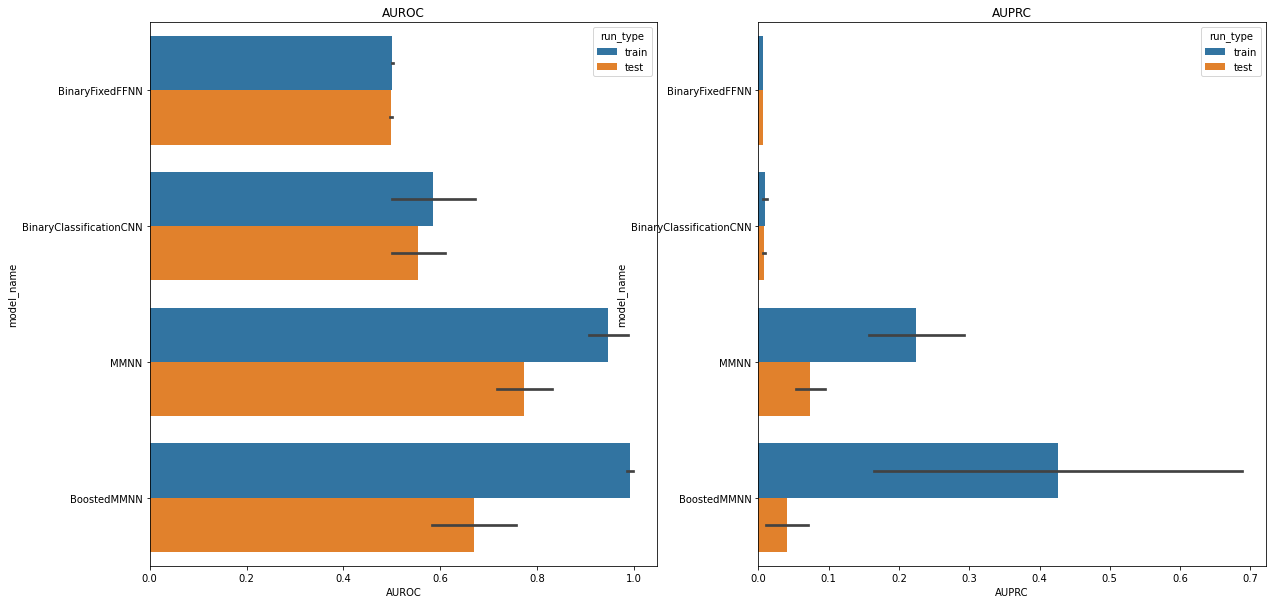

In [38]:
_, axs = plt.subplots(ncols=2, figsize=(20, 10))
sbn.barplot(
    x="AUROC",
    y="model_name",
    data=all_performance_history,
    hue="run_type",
    orient="h",
    ax=axs[0],
    ci="sd"
)
axs[0].set_title("AUROC")

sbn.barplot(
    x="AUPRC",
    y="model_name",
    data=all_performance_history,
    hue="run_type",
    orient="h",
    ax=axs[1]
)
_ = axs[1].set_title("AUPRC")